In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
import os

In [13]:
# Get the data for the SP500 by defining the ticker
sp500 = yf.Ticker("^GSPC")

In [14]:
#The history of all the trading days (market open days)
sp500 = sp500.history(period="max")
sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


# A bit of data visualization and cleaning

<Axes: title={'center': 'S&P 500'}, xlabel='Date'>

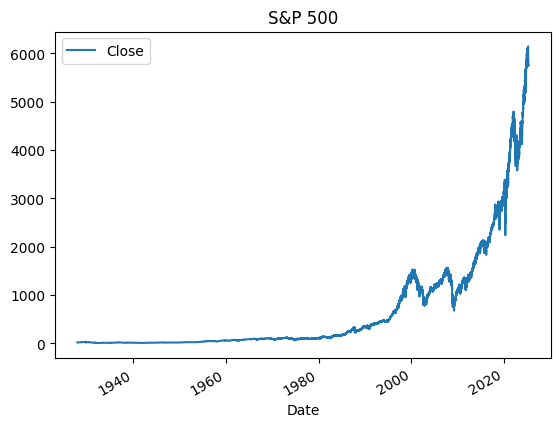

In [15]:
sp500.plot(y='Close', use_index=True ,title='S&P 500')

In [16]:
# Unuseful columns
del sp500['Dividends']
del sp500['Stock Splits']

In [17]:
# We will try to predict if the closing price of the next day will be higher or
sp500["Tomorrow"] = sp500["Close"].shift(-1)


In [18]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)


In [19]:
sp500.tail(5)

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2025-03-03 00:00:00-05:00,5968.330078,5986.089844,5810.910156,5849.720215,5613850000,5778.149902,0
2025-03-04 00:00:00-05:00,5811.979980,5865.080078,5732.589844,5778.149902,6138110000,5842.629883,1
2025-03-05 00:00:00-05:00,5781.359863,5860.589844,5742.350098,5842.629883,5285970000,5738.520020,0
2025-03-06 00:00:00-05:00,5785.870117,5812.080078,5711.640137,5738.520020,5165080000,5770.200195,1
2025-03-07 00:00:00-05:00,5726.009766,5783.009766,5666.290039,5770.200195,5705140000,NaN,0


In [20]:
# We will only use the last 25 years because too old data is not that pertinent
sp500 = sp500.loc["1990-01-01":].copy()
sp500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0


# Training an initial machine learning model

For our initial model I will use a RandomForestClassifier
It is a good model to start with because :
- Resistent to overfit
- Is simple to use
- Run quite quickly
- Picks up non linear relationships

In [21]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

### Let's now measure how the model is doing

In [22]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.4838709677419355

## Enable back-testing

In [23]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined


In [24]:
def backtest(data, model, predictors, start=2500, step=250) :
    all_predictions = []
    for i in range(start, len(data), step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:i+step].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [25]:
predictions = backtest(sp500, model, predictors)


In [26]:
#Numbers of days it predicted up or down
predictions["Predictions"].value_counts()

Predictions
0    3726
1    2635
Name: count, dtype: int64

In [27]:
#Precision of the model with backtesting
precision_score(predictions["Target"], predictions["Predictions"])

0.5286527514231499

In [28]:
#Percentage of days where the market went up
predictions["Target"].value_counts() / predictions.shape[0]


# For now the result of the models are worse than the natural probability of the market going up

Target
1    0.535922
0    0.464078
Name: count, dtype: float64

## Adding additional predictors to the model

In [29]:
# 2 days, 5 days, 60 days, 250 days, 1000 days
horizons = [2,5,60,250,1000] 
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [30]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])
sp500.tail()

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2025-03-03 00:00:00-05:00,5968.330078,5986.089844,5810.910156,5849.720215,5613850000,5778.149902,0,0.991124,1.0,0.988893,2.0,0.973987,30.0,1.043237,140.0,1.268403,529.0
2025-03-04 00:00:00-05:00,5811.979980,5865.080078,5732.589844,5778.149902,6138110000,5842.629883,1,0.993845,0.0,0.982679,2.0,0.962797,29.0,1.029998,140.0,1.252374,528.0
2025-03-05 00:00:00-05:00,5781.359863,5860.589844,5742.350098,5842.629883,5285970000,5738.520020,0,1.005549,1.0,0.997493,2.0,0.974201,29.0,1.040925,141.0,1.265828,528.0
2025-03-06 00:00:00-05:00,5785.870117,5812.080078,5711.640137,5738.520020,5165080000,5770.200195,1,0.991010,1.0,0.983852,2.0,0.957737,29.0,1.021915,140.0,1.242788,527.0
2025-03-07 00:00:00-05:00,5726.009766,5783.009766,5666.290039,5770.200195,5705140000,NaN,0,1.002753,1.0,0.995575,2.0,0.963883,29.0,1.027108,140.0,1.249162,527.0


### Implementing the improvements

In [31]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [32]:
#Adapting the predict function
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
predictions = backtest(sp500, model, new_predictors)



In [34]:
predictions["Predictions"].value_counts()
# We can see that we bought far less

Predictions
0.0    4496
1.0     865
Name: count, dtype: int64

In [35]:
predictions["Target"].value_counts() / predictions.shape[0]

# Market went up 54.5% of the time

Target
1    0.545421
0    0.454579
Name: count, dtype: float64

In [36]:
precision_score(predictions["Target"], predictions["Predictions"])

# We can see that the precision is better than the natural probability of the market going up

0.5722543352601156

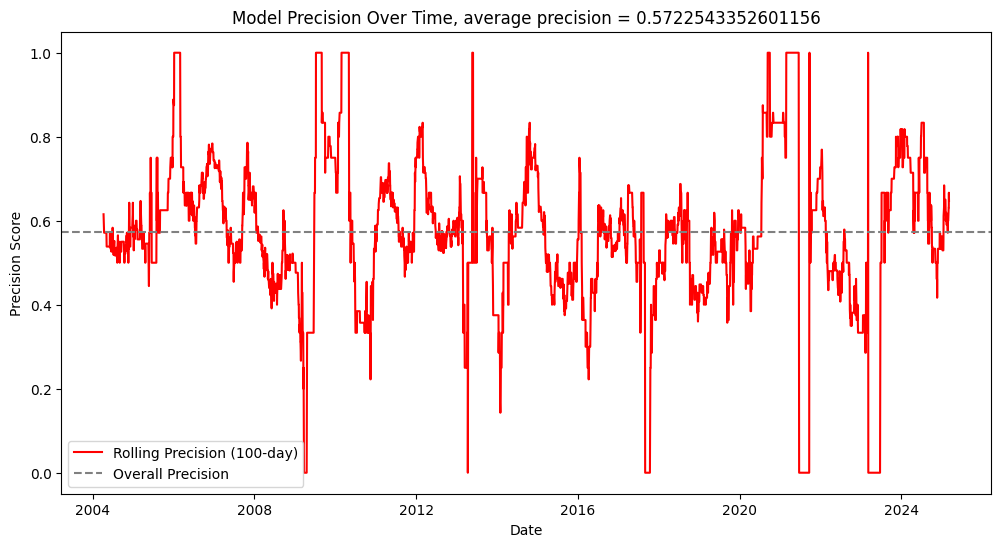

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score

def plot_precision_over_time(all_predictions, window=100):
    # Ensure correct indexing
    all_predictions = all_predictions.dropna()

    # Compute rolling precision
    rolling_precision = all_predictions["Predictions"].rolling(window).apply(
        lambda x: precision_score(all_predictions["Target"].loc[x.index], x, zero_division=0)
    )

    # Plot precision over time
    plt.figure(figsize=(12, 6))
    plt.plot(rolling_precision.index, rolling_precision, color="red", label=f"Rolling Precision ({window}-day)")
    plt.axhline(y=precision_score(predictions["Target"], predictions["Predictions"]), color="gray", linestyle="dashed", label="Overall Precision")
    
    plt.xlabel("Date")
    plt.ylabel("Precision Score")
    plt.title("Model Precision Over Time, average precision = " + str(precision_score(predictions["Target"], predictions["Predictions"])))
    plt.legend()
    plt.show()

# Run the function
plot_precision_over_time(predictions)
